In [20]:
from transformers import Trainer, TrainingArguments,EarlyStoppingCallback
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import math


In [21]:
import torch, torchvision, torchaudio
print("PyTorch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)


PyTorch: 2.8.0+cu128
CUDA available? True
Device count: 1
Current device: 0
Device name: NVIDIA RTX A5000


In [22]:
import numpy as np

data = np.loadtxt("ENDF_B-VIII.1_AU-197(N,G)AU-198.yaml")  # (x, y)
print(data.shape)

(20330, 2)


In [23]:
x_raw = data[:, 0].astype(np.float32)
y_raw = data[:, 1].astype(np.float32)
x_log = np.log10(x_raw)
y_log = np.log10(y_raw)

In [24]:
from datasets import Dataset

full_ds = Dataset.from_dict({"x": x_log.tolist(), "y": y_log.tolist()})
ds = full_ds.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = ds["train"], ds["test"]

In [25]:
# ---------- 4) Standardize using TRAIN stats ----------
x_mean, x_std = float(np.mean(train_ds["x"])), float(np.std(train_ds["x"]))
y_mean, y_std = float(np.mean(train_ds["y"])), float(np.std(train_ds["y"]))


def standardize(example):
    example["input"] = (example["x"] - x_mean) / x_std
    example["labels"] = (example["y"] - y_mean) / y_std
    del example["x"]
    del example["y"]
    return example


train_ds = train_ds.map(standardize)
eval_ds  = eval_ds.map(standardize)


Map:   0%|          | 0/18297 [00:00<?, ? examples/s]

Map:   0%|          | 0/2033 [00:00<?, ? examples/s]

In [26]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [27]:
class MLP(nn.Module):
    def __init__(self, dim=512, activation=nn.Tanh(), p_drop=0.05):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            activation,
            nn.Dropout(p_drop),
            nn.Linear(dim, dim),
            nn.Dropout(p_drop)
        )
        self.activation = activation
        
    def forward(self, x):
        return self.activation(x + self.block(x))


# In[9]:


class kamma_2(nn.Module):
    def __init__(self, in_dim=1, dim=128, depth=3, p_drop=0.05,activation=nn.Tanh()):
        super().__init__()
        
        self.inp = nn.Linear(in_dim, dim)
        self.blocks = nn.ModuleList([MLP(dim,activation,p_drop) for _ in range(depth)])
        self.out = nn.Linear(dim, 1)
        self.loss_fn = nn.HuberLoss(delta=1.0)

    def forward(self, input: torch.Tensor, labels: torch.Tensor = None):        
        h = self.inp(input)
        for blk in self.blocks:
            h = blk(h)
        logits = self.out(h)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


# In[10]:



In [28]:
model = kamma_2(in_dim=1, dim=128, depth=10, p_drop=0.1,activation=nn.SiLU()).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(model)

kamma_2(
  (inp): Linear(in_features=1, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x MLP(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
      (activation): SiLU()
    )
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
  (loss_fn): HuberLoss()
)


In [29]:
# Check specific parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")
    break  # Just check the first one, usually all are on same device

inp.weight: cuda:0


In [30]:
def num_of_param(model):
    return sum(p.numel() for p in model.parameters())
num_of_param(model)

330625

In [31]:
def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.array(preds).reshape(-1)
    labels = eval_pred.label_ids.reshape(-1)

    mse  = float(np.mean((preds - labels) ** 2))
    rmse = float(math.sqrt(mse))
    mae  = float(np.mean(np.abs(preds - labels)))
    ss_res = float(np.sum((labels - preds) ** 2))
    
    ss_tot = float(np.sum((labels - np.mean(labels)) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


def collate_scalar_to_column(batch):
    inputs = torch.tensor([ex["input"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    return {"input": inputs, "labels": labels}


In [54]:
training_args = TrainingArguments(
            output_dir='./results',
            learning_rate=1e-4,
            per_device_train_batch_size=512,  
            per_device_eval_batch_size=512,
            max_steps=50000,  # Replace with your desired number of steps
            weight_decay=0.02,
            eval_strategy='steps', 
            eval_steps=2500,  #the save step should be a multiple of eval step, savestep=500 by default
            lr_scheduler_type="cosine",
            warmup_ratio=0.1,
            # metric_for_best_model="mse",
        )
# ---------------- 7) Trainer ----------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_dataset,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_scalar_to_column,
)

In [55]:
print(f"Trainer device: {trainer.args.device}")

Trainer device: cuda:0


In [56]:
trainer.train()

Step,Training Loss,Validation Loss,Mse,Rmse,Mae,R2
2500,0.292200,0.272486,0.569390,0.754579,0.618968,0.420129
5000,0.293800,0.288444,0.607679,0.779537,0.639035,0.381136
7500,0.293300,0.277558,0.580760,0.762076,0.627068,0.408550
10000,0.293100,0.283753,0.596061,0.772050,0.631592,0.392967
12500,0.292100,0.275315,0.575858,0.758853,0.621546,0.413542
15000,0.291300,0.272207,0.570059,0.755023,0.617617,0.419448
17500,0.290600,0.275706,0.576082,0.759000,0.622865,0.413314
20000,0.289900,0.272123,0.568400,0.753923,0.618364,0.421137
22500,0.289500,0.269487,0.562100,0.749733,0.615787,0.427553
25000,0.288600,0.269558,0.562890,0.750260,0.615818,0.426749


TrainOutput(global_step=50000, training_loss=0.2883101901245117, metrics={'train_runtime': 1272.5842, 'train_samples_per_second': 20116.547, 'train_steps_per_second': 39.29, 'total_flos': 0.0, 'train_loss': 0.2883101901245117, 'epoch': 1250.0})

In [57]:
pred_train = trainer.predict(train_ds)
out_pred=pred_train.predictions

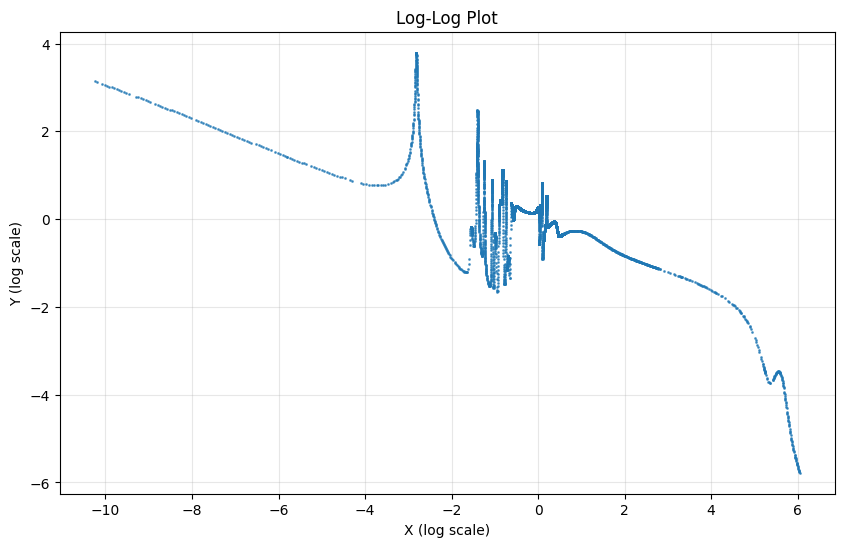

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming
x=np.array(train_ds["input"])
y = out_pred# All rows, column 1

# Log-log plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', alpha=0.7, markersize=1)
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.title('Log-Log Plot')
plt.grid(True, alpha=0.3)

# Save the figure before showing it
plt.savefig('log_log_plot.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [60]:
torch.save(model.state_dict(), 'model.pth')

In [61]:
torch.save(model, 'entire_model.pth')

In [53]:
from datasets import concatenate_datasets

# Suppose your datasets are named `dataset1` and `dataset2`
# (each like: Dataset({ features: ['input', 'labels'], num_rows: ... }))

combined_dataset = concatenate_datasets([train_ds, eval_ds])

print(combined_dataset)


Dataset({
    features: ['input', 'labels'],
    num_rows: 20330
})


In [49]:
eval_ds

Dataset({
    features: ['input', 'labels'],
    num_rows: 2033
})